<center> <h1>  A: DATA PREPROCESSING </h1> </center>

## 1. Prepare dataset

### 1.1. Import libraries

In [1]:
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
from datasets import DatasetDict, load_dataset
from torchvision.transforms import ToTensor

In [2]:
SEED = 42
TRAIN_ratios = 0.75
VALIDATE_ratios = 0.10
TEST_ratios = 1 - TRAIN_ratios - VALIDATE_ratios

### 1.2. Load dataset

In [3]:
raw_dataset: DatasetDict = load_dataset("OleehyO/latex-formulas", "cleaned_formulas")

In [4]:
print(f"Dataset shape: {raw_dataset.shape}")

Dataset shape: {'train': (552340, 2)}


### 1.3. Split dataset

In [5]:
first_split = raw_dataset["train"].train_test_split(
    train_size=TRAIN_ratios, seed=SEED, shuffle=True
)

second_split = first_split["test"].train_test_split(
    train_size=VALIDATE_ratios / (VALIDATE_ratios + TEST_ratios),
    seed=SEED,
    shuffle=True,
)

train_set = first_split["train"]
validate_set = second_split["train"]
test_set = second_split["test"]

dataset = DatasetDict(
    {
        "train": train_set,
        "validate": validate_set,
        "test": test_set,
    }
)

print("Results after splitting:")
print("- Total records:", sum(len(v) for v in dataset.values()))
print("- Counts:")
for split_name, split_data in dataset.items():
    print(f"  + {split_name}: {len(split_data)}")

Results after splitting:
- Total records: 552340
- Counts:
  + train: 414255
  + validate: 55234
  + test: 82851


## 2. EDA

### 2.1. Image size analysis

In [6]:
widths = []
heights = []
train_set = dataset["train"]
for i in range(len(train_set)):
    w, h = train_set[i].get("image").size
    widths.append(w)
    heights.append(h)

In [7]:
widths = np.array(widths)
heights = np.array(heights)
ratios = widths / heights

In [9]:
print("Image widths stats:")
print(f"- Min: {widths.min()}")
print(f"- Max: {widths.max()}")
print(f"- Mean: {widths.mean():.2f}")
print(f"- Median: {np.median(widths)}")
print(f"- Std: {widths.std():.2f}")
print("Image heights stats:")
print(f"- Min: {heights.min()}")
print(f"- Max: {heights.max()}")
print(f"- Mean: {heights.mean():.2f}")
print(f"- Median: {np.median(heights)}")
print(f"- Std: {heights.std():.2f}")
print("Width/Height ratios stats:")
print(f"- Min: {ratios.min():.2f}")
print(f"- Max: {ratios.max():.2f}")
print(f"- Mean: {ratios.mean():.2f}")
print(f"- Median: {np.median(ratios):.2f}")
print(f"- Std: {ratios.std():.2f}")

Image widths stats:
- Min: 28
- Max: 746
- Mean: 325.73
- Median: 309.0
- Std: 134.02
Image heights stats:
- Min: 4
- Max: 386
- Mean: 65.34
- Median: 62.0
- Std: 28.53
Width/Height ratios stats:
- Min: 1.25
- Max: 58.25
- Mean: 5.69
- Median: 4.94
- Std: 3.22


[Text(0.5, 1.0, 'Image Width Distribution')]

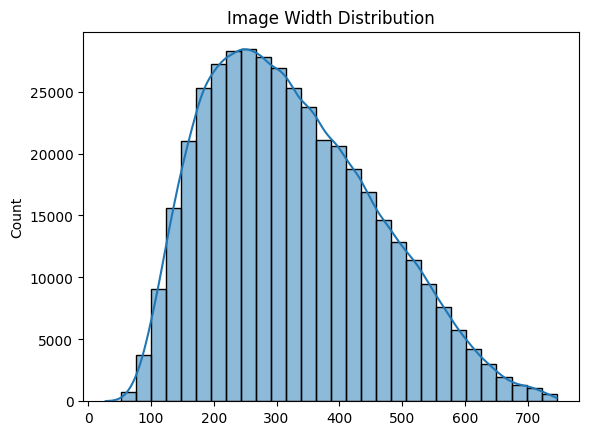

In [10]:
sns.histplot(widths, bins=30, kde=True).set(title="Image Width Distribution")

[Text(0.5, 1.0, 'Image Height Distribution')]

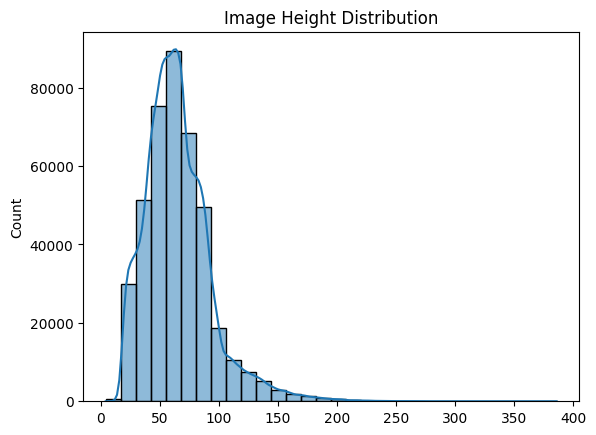

In [11]:
sns.histplot(heights, bins=30, kde=True).set(title="Image Height Distribution")

[Text(0.5, 1.0, 'Image Width/Height ratios Distribution')]

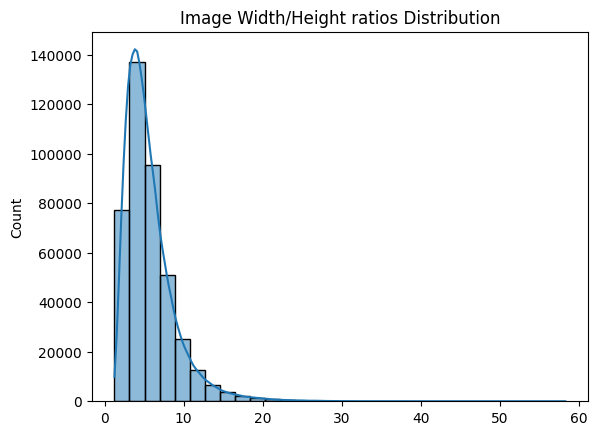

In [12]:
sns.histplot(ratios, bins=30, kde=True).set(
    title="Image Width/Height ratios Distribution"
)

### 2.2. Convert images to tensors

In [ ]:
# 2.3 Resize & pad images for model input
from PIL import Image
import numpy as np

TARGET_HEIGHT = 64  # Close to median (62); balanced resolution & speed
MAX_WIDTH = 800  # Slightly above max expected post-scale width
PAD_VALUE = 255  # White background (black text)
MIN_BASE_HEIGHT = 16  # Prevent extreme upscaling artifacts

print(f"Resize config -> TARGET_HEIGHT={TARGET_HEIGHT}, MAX_WIDTH={MAX_WIDTH}")


def resize_and_pad(example):
    img = example["image"].convert("L")  # grayscale
    w, h = img.size

    effective_h = max(h, MIN_BASE_HEIGHT)
    scale = TARGET_HEIGHT / effective_h
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))

    # Constrain width if overflow
    if new_w > MAX_WIDTH:
        scale = MAX_WIDTH / w
        new_w = MAX_WIDTH
        new_h = int(round(h * scale))

    img_resized = img.resize((new_w, new_h), Image.LANCZOS)

    canvas = Image.new("L", (MAX_WIDTH, TARGET_HEIGHT), color=PAD_VALUE)
    top = (TARGET_HEIGHT - new_h) // 2
    canvas.paste(img_resized, (0, top))

    example["image_resized"] = canvas
    example["orig_w"], example["orig_h"] = w, h
    example["scaled_w"], example["scaled_h"] = new_w, new_h
    example["scale"] = scale
    return example


processed_dataset = dataset.map(resize_and_pad, num_proc=4)

# Basic distribution check on scaled widths
scaled_widths = np.array(
    [
        processed_dataset["train"][i]["scaled_w"]
        for i in range(min(5000, len(processed_dataset["train"])))
    ]
)
print(
    "Scaled width stats (subset): min=",
    scaled_widths.min(),
    "max=",
    scaled_widths.max(),
    "mean=",
    scaled_widths.mean().round(2),
)

print("Columns now:")
print({split: processed_dataset[split].column_names for split in processed_dataset})

sample = processed_dataset["train"][0]
print(
    "Sample original / scaled:",
    (sample["orig_w"], sample["orig_h"]),
    "->",
    (sample["scaled_w"], sample["scaled_h"]),
)

In [ ]:
# Visualize a few resized samples to verify padding & aspect ratios
from IPython.display import display

np.random.seed(SEED)


def show_samples(ds, n=3):
    idxs = np.random.choice(len(ds), size=min(n, len(ds)), replace=False)
    for idx in idxs:
        ex = ds[idx]
        print(
            f"idx={idx} | orig={ex['orig_w']}x{ex['orig_h']} -> scaled={ex['scaled_w']}x{ex['scaled_h']}, scale={ex['scale']:.3f}"
        )
        display(ex["image_resized"])


show_samples(processed_dataset["train"], n=3)